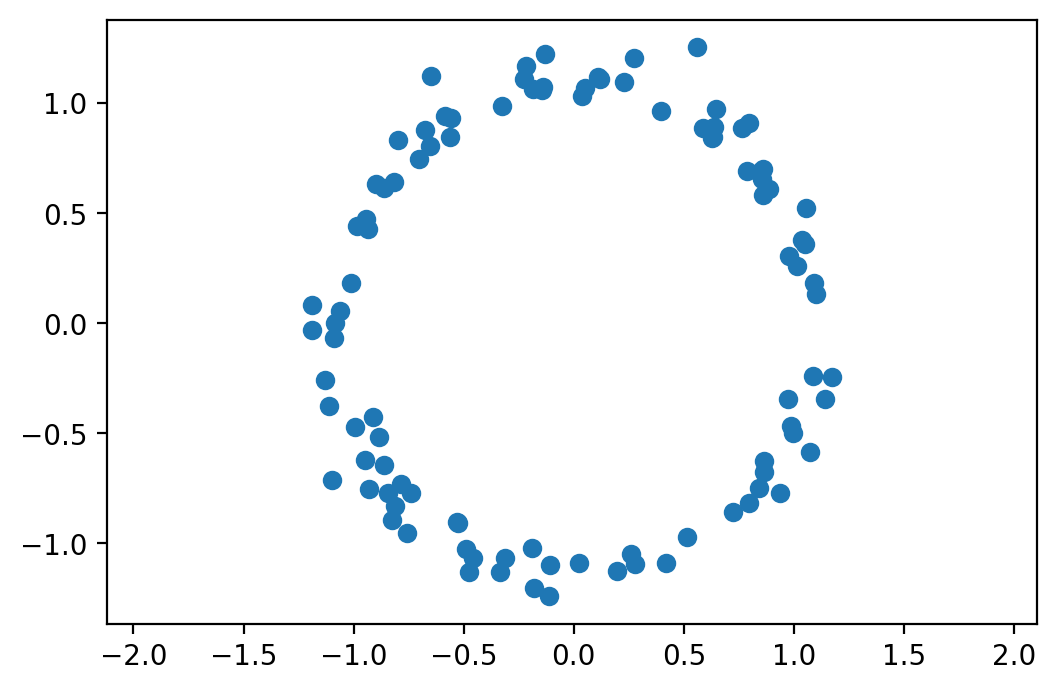

In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

device = 'cuda' if torch.cuda.is_available() else 'cpu'

N_dist = torch.distributions.MultivariateNormal(torch.FloatTensor([0,0]), torch.FloatTensor([[1,0],[0,1]]))
z = N_dist.sample((100,))
d = []
for z_i in z:
    d.append(z_i/10 + z_i/torch.linalg.norm(z_i))
data = torch.FloatTensor([d_i.numpy() for d_i in d])
plt.scatter(data[:,0], data[:,1])
plt.axis('equal')
plt.show()


In [2]:
# d0 = 784; d1 = 512
d0 = 2; d1 = 784; d2 = 512
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(d0, d1)
        self.linear2 = nn.Linear(d1, d2)
        self.linear3 = nn.Linear(d2, latent_dims)

    def forward(self, x):
        # x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        return self.linear3(x)

class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, d2)
        self.linear2 = nn.Linear(d2, d1)
        self.linear3 = nn.Linear(d1, d0)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = F.relu(self.linear2(z))
        z = torch.sigmoid(self.linear3(z))
        return z

class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)


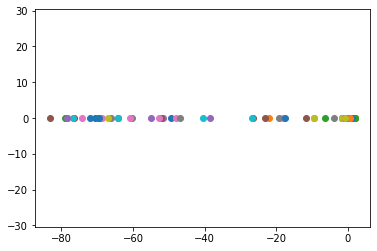

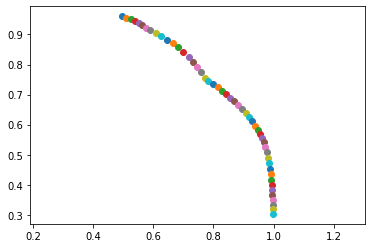

In [6]:
def train(autoencoder, data, epochs=100):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        for x in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            loss.backward()
            opt.step()
    return autoencoder

latent_dims = 1
autoencoder = Autoencoder(latent_dims).to(device) # GPU

# data = torch.utils.data.DataLoader(
#         torchvision.datasets.MNIST('./data',
#                transform=torchvision.transforms.ToTensor(),
#                download=True),
#         batch_size=128,
#         shuffle=True)


autoencoder = train(autoencoder, data)

def plot_latent(autoencoder, data, num_batches=1000):
    for i, x in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z, np.zeros_like(z), cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break
    plt.axis('equal')
    plt.show()

plot_latent(autoencoder, data)

def plot_reconstructed(autoencoder, n=50):
    for z in np.linspace(0.0,1.0,n):
        z = torch.Tensor([z]).to(device)
        x_hat = autoencoder.decoder(z)
        x_hat = x_hat.to('cpu').detach().numpy()
        # print(z.tolist(), x_hat)
        plt.scatter(x_hat[0], x_hat[1])
    plt.axis('equal')
    plt.show()

plot_reconstructed(autoencoder)

In [4]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(d0, d1)
        self.linear2 = nn.Linear(d1, d2)
        self.linear3 = nn.Linear(d2, latent_dims)
        self.linear4 = nn.Linear(d2, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        # x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        mu =  self.linear3(x)
        sigma = torch.exp(self.linear4(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)



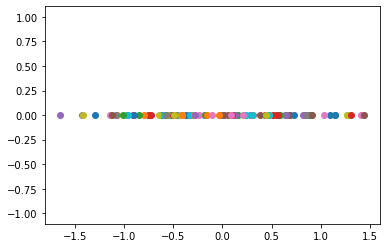

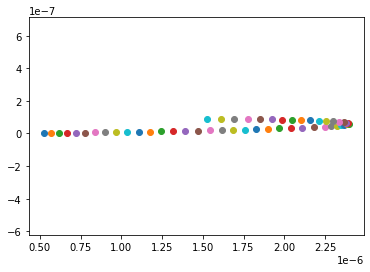

In [5]:
def train(vae, data, epochs=1000):
    opt = torch.optim.Adam(vae.parameters())
    for epoch in range(epochs):
        for x in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            loss.backward()
            opt.step()
    return vae

vae = VariationalAutoencoder(latent_dims).to(device) # GPU
vae = train(vae, data)

plot_latent(vae, data)
plot_reconstructed(vae)